# California Housing Prices Prediction

# Overview
The task is to use California census data to build a model of housing prices in the state. This data includes metrics such as the population, median income, and median housing price for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data. The model will learn from this data and be able to predict the median housing price in any district, given all the other metrics.

# Business Understanding
The model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system, along with many other signals. This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.

# Data Understanding

## Read in Modules and Data

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

import matplotlib.image as mpimg
from pandas.plotting import scatter_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

## Get the data

In [216]:
housing = pd.read_csv("data/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


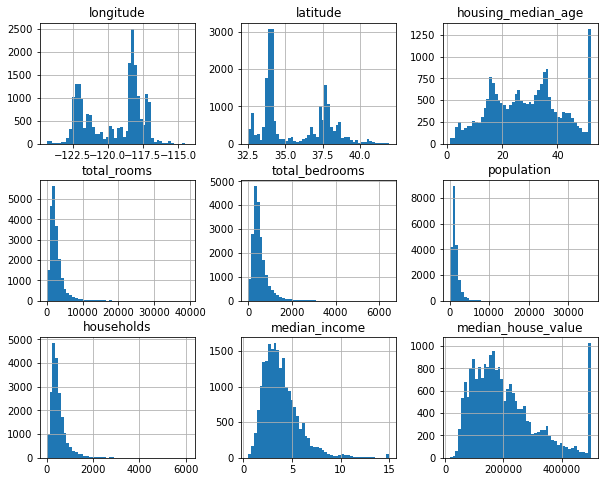

In [218]:
housing.hist(bins=50, figsize=(10,8))
#plt.savefig("images/attribute_histogram_plots.png", format="png", dpi=300)
plt.show()

In [14]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

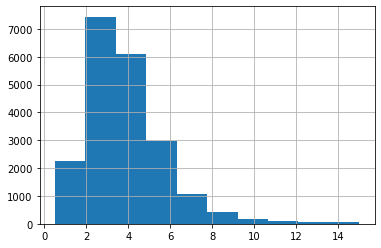

In [16]:
housing["median_income"].hist()

In [21]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

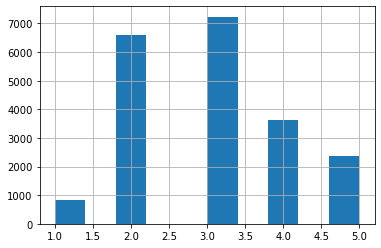

In [23]:
housing["income_cat"].hist()

In [36]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [34]:
split.get_n_splits()

1

In [37]:
strat_test_set["income_cat"].value_counts(normalize=True)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [38]:
housing["income_cat"].value_counts(normalize=True)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [43]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

# Discover and visualize the data to gain insights

In [46]:
housing = strat_train_set.copy()

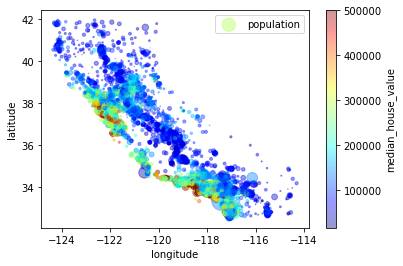

In [64]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, s=housing["population"]/100, label="population", 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False)
plt.legend()
#plt.savefig("images/housing_prices_scatterplot.png", format="png", dpi=300)

In [53]:
# Download the California image
images_path = os.path.join(".", "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7fce292e36a0>)

In [58]:
os.path.join(images_path, filename)

'./images/end_to_end_project/california.png'

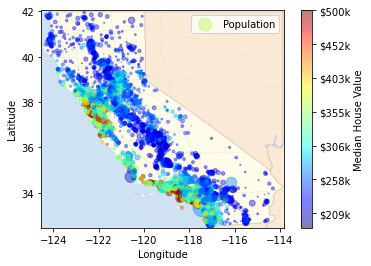

In [65]:
california_img=mpimg.imread("images/california.png")

ax = housing.plot(kind="scatter", x="longitude", y="latitude", s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=False, alpha=0.4)

plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5, cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude")
plt.xlabel("Longitude")

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values])
cbar.set_label('Median House Value')

plt.legend()
#plt.savefig("images/california_housing_prices_plot.png", format="png", dpi=300)
plt.show()

In [66]:
corr_matrix = housing.corr()

In [39]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

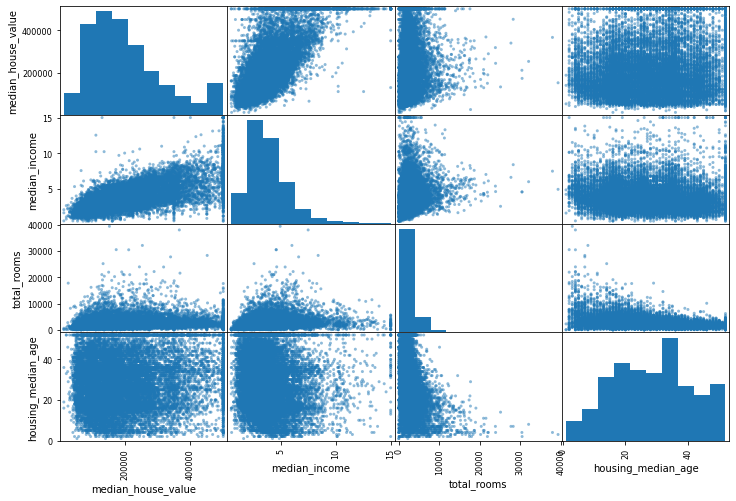

In [73]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
#plt.savefig("images/scatter_matrix_plot.png", format="png", dpi=300)
plt.show()

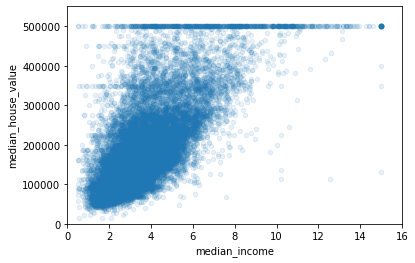

In [74]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)         
plt.axis([0, 16, 0, 550000])
#plt.savefig("images/income_vs_house_value_scatterplot.png", format="png", dpi=300)

In [75]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [76]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

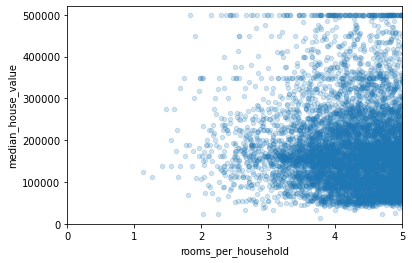

In [78]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value", alpha=0.2)
plt.axis([0, 5, 0, 520000])
#plt.savefig("images/rooms_vs_house_value_scatterplot.png", format="png", dpi=300)

In [79]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Prepare the data for Machine Learning algorithms

In [80]:
# drop labels for training set
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

In [84]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)]
sample_incomplete_rows.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [85]:
# option 1
sample_incomplete_rows.dropna(subset=["total_bedrooms"])

# option 2
sample_incomplete_rows.drop("total_bedrooms", axis=1)   

# option 3
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True)

/Users/mbcn345/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [88]:
imputer = SimpleImputer(strategy="median")

In [90]:
# housing_num = housing.select_dtypes(include=[np.number])
housing_num = housing.drop("ocean_proximity", axis=1)

In [91]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [95]:
# Check that this is the same as manually computing the median of each attribute:
imputer.statistics_, housing_num.median().values

(array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]),
 array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
         408.    ,    3.5409]))

In [96]:
# Transform the training set:
X = imputer.transform(housing_num)

In [98]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing.index)                      

In [106]:
housing_tr.loc[sample_incomplete_rows.index]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662
...,...,...,...,...,...,...,...,...
3376,-118.28,34.25,29.0,2559.0,433.0,1886.0,769.0,2.6036
4691,-118.37,34.07,50.0,2519.0,433.0,1117.0,516.0,4.3667
6052,-117.76,34.04,34.0,1914.0,433.0,1564.0,328.0,2.8347
17198,-119.75,34.45,6.0,2864.0,433.0,1404.0,603.0,5.5073


In [109]:
# categorical input feature, `ocean_proximity`:
housing_cat = housing[["ocean_proximity"]]

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [65]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [114]:
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [115]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [116]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [117]:
# get the column indices
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c in col_names]

In [118]:
# create a custom transformer to add extra attributes:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self  # nothing else to do
    
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]                        
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [127]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)
# housing_extra_attribs = attr_adder.fit_transform(housing.values)

In [129]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs, columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
                                     index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847


In [130]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# build a pipeline for preprocessing the numerical attributes

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy="median")), 
                         ('attribs_adder', CombinedAttributesAdder()), 
                         ('std_scaler', StandardScaler())])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [139]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([("num", num_pipeline, num_attribs),
                                   ("cat", OneHotEncoder(), cat_attribs)])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

In [77]:
housing_prepared.shape

(16512, 16)

# Select and train a model 

In [141]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [142]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
lin_rmse

68628.19819848923

In [145]:
from sklearn.metrics import mean_absolute_percentage_error

lin_mape = mean_absolute_percentage_error(housing_labels, housing_predictions)
lin_mape

0.2846576408476219

# Fine-tune your model

In [ ]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [170]:
from sklearn.model_selection import cross_val_score

tree_reg = DecisionTreeRegressor(random_state=42)
tree_rmse_scores = -cross_val_score(tree_reg, housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [165]:
lin_rmse_scores = -cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
                             
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Standard deviation: 2731.674001798342


In [171]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
forest_rmse

18603.515021376355

In [168]:
from sklearn.model_selection import cross_val_score

forest_rmse_scores = -cross_val_score(forest_reg, housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
                                
display_scores(forest_rmse_scores)

Scores: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Mean: 50182.303100336096
Standard deviation: 2097.0810550985693


In [169]:
scores = -cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_root_mean_squared_error", cv=10)
pd.Series(scores).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [172]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_rmse = mean_squared_error(housing_labels, housing_predictions, squared=False)
svm_rmse

111094.6308539982

In [173]:
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, # try 12 (3×4) combinations of hyperparameters
              {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}] # then try 6 (2×3) combinations with bootstrap set as False

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [176]:
# The best hyperparameter combination found:
grid_search.best_params_, grid_search.best_estimator_

({'max_features': 8, 'n_estimators': 30},
 RandomForestRegressor(max_features=8, n_estimators=30, random_state=42))

In [184]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {'n_estimators': randint(low=1, high=200),
                  'max_features': randint(low=1, high=8)}

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fce28171790>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fce2834f220>},
                   random_state=42, scoring='neg_mean_squared_error')

In [185]:
rnd_search.best_params_, rnd_search.best_estimator_

({'max_features': 7, 'n_estimators': 180},
 RandomForestRegressor(max_features=7, n_estimators=180, random_state=42))

In [188]:
feature_importances = grid_search.best_estimator_.feature_importances_
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'median_income'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'pop_per_hhold'),
 (0.07334423551601243, 'longitude'),
 (0.06290907048262032, 'latitude'),
 (0.056419179181954014, 'rooms_per_hhold'),
 (0.053351077347675815, 'bedrooms_per_room'),
 (0.04114379847872964, 'housing_median_age'),
 (0.014874280890402769, 'population'),
 (0.014672685420543239, 'total_rooms'),
 (0.014257599323407808, 'households'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [205]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
final_rmse

47730.22690385927

In [206]:
# compute a 95% confidence interval for the test RMSE:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1, loc=squared_errors.mean(), scale=stats.sem(squared_errors))) 

array([45685.10470776, 49691.25001878])

In [207]:

m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776014, 49691.25001877871)

In [208]:
# use a z-scores 
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136594, 49690.68623889426)

# Extra material

## A full pipeline with both preparation and prediction

In [211]:
full_pipeline_with_predictor = Pipeline([("preparation", full_pipeline),
                                         ("linear", LinearRegression())])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(housing)

array([210644.60459286, 317768.80697211, 210956.43331178, ...,
        95464.57062437, 214353.22541713, 276426.4692067 ])

## Model persistence using joblib

In [114]:
my_model = full_pipeline_with_predictor

In [115]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
my_model_loaded = joblib.load("my_model.pkl") # DIFF

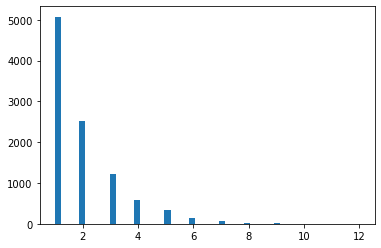

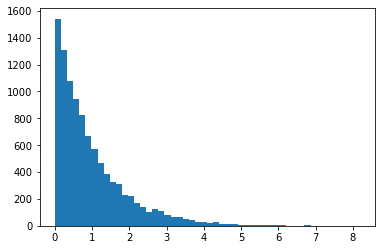

In [212]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

In [214]:
geom_distrib.shape

(10000,)

The housing prices is predicted for Kings County in Seattle WA. The model solve the problems for pridiction satisfactorily. New features are created to understand the questions. In any of these cases, it is also totally encouraged to revisit the earlier steps to optimze the features and model techniques.